#Preparational steps
Checking information about attached GPU resource.

In [ ]:
!nvidia-smi

Tue Apr  2 16:05:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
import numpy as np
import keras
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
from textwrap import wrap
from PIL import Image, ImageFile, UnidentifiedImageError
# Increasing maximum limit size for pixels per input image
ImageFile.LOAD_TRUNCATED_IMAGES = True
Image.MAX_IMAGE_PIXELS = 933120000

In [ ]:
# Importing Pytorch and transformers from HuggingFace
import torch
# Import nn module for building stacked layers and optimizers
from torch import nn, optim
import torchvision
from torchvision import datasets, models, transforms
# Import modules for dataset configuration and loading
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
import torch.optim.lr_scheduler as lr_scheduler

In [ ]:
# Importing modules for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
# Importing visualization tools
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

# Setting style of matplotlib graphic visualization
%matplotlib inline
%config InlineBackend.figure_format="retina"

# Setting style of seaborn graphic visualization
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
COLOR_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(COLOR_PALETTE))

# Setting parameter figure sizes
rcParams["figure.figsize"] = 12, 8

Checking if GPU resource is accessible.

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Assigning available ressource to device variable, preferrably GPU resource
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Print out if GPU or CPU is allocated
if str(device) == "cpu":
    print("CPU is allocated.")
else:
    print("GPU is allocated.")

GPU is allocated.


#Initializing and preparing Fakeddit-Benchmark dataset
Helper function to read in tsv files and return clean pandas dataframe.

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
# Clear any cached authorization
!rm -rf /root/.config/Google/DriveFS

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive/"

 6013-6003-6010-6012-fsmd.zip
'Atp_2(Jahid)'
'Bachelor Certificate.pdf'
'Colab Notebooks'
'COMPUTER GRAPHICS [F].zip'
'Copy of Zapier: Free email signatures for Gmail.gdoc'
'Cover Letter Siam.docx'
 CV
 Ema
 FA-KES-Dataset.csv
 IELTS.pdf
 Maya
'Md. Samiul Alam Siam.docx'
'Md. Samiul Alam Siam.pdf'
'Md Samiul Alam Siam Picture.jpg'
'Md Samiul Alam Siam Signature.jpg'
 Norsk
'Real time big data management - Pie chart 1.gsheet'
 Self
 Suma
 Syeed
 Thesis
 WELFake_Dataset.csv


In [ ]:
import pandas as pd

# Base path where TSV files are stored
base_path = '/content/drive/My Drive/Thesis/dataset/'

# Base path where images are stored
base_path_image = '/content/drive/My Drive/Thesis/images/private_image_set/'

In [ ]:
file_test_name = "multimodal_test_public.tsv"
file_train_name = "multimodal_train.tsv"
file_validate_name = "multimodal_validate.tsv"

df_test = pd.read_csv(base_path + file_test_name, sep='\t')
df_train = pd.read_csv(base_path + file_train_name, sep='\t')
df_validate = pd.read_csv(base_path + file_validate_name, sep='\t')

In [ ]:
df_validate.head(5)

,author,clean_title,created_utc,domain,hasImage,id,image_url,linked_submission_id,num_comments,score,subreddit,title,upvote_ratio,2_way_label,3_way_label,6_way_label
0,singingdart7854,my xbox controller says hi,1.567436e+09,i.redd.it,True,cypw96,https://preview.redd.it/l0ga0tug17k31.jpg?widt...,NaN,4.0,25,mildlyinteresting,My Xbox controller says hi,0.72,1,0,0
1,mandal0re,new image from the mandalorian,1.567745e+09,i.imgur.com,True,d0bzlq,https://external-preview.redd.it/VX7bXDu9Gl8UZ...,NaN,5.0,21,photoshopbattles,PsBattle: New image from The Mandalorian,0.92,1,0,0
2,HE_WHO_DRUELS,say hello to my little friend,1.461468e+09,NaN,True,d2ezoob,http://i.imgur.com/F1Zbl3D.jpg,4g6bp9,NaN,10,psbattle_artwork,Say hello to my little friend!,NaN,0,2,4
3,eNaRDe,watch your step little one,1.408047e+09,NaN,True,cjqctpw,http://i.imgur.com/KRyMjn1.jpg,2diyh3,NaN,1,psbattle_artwork,Watch your step little one,NaN,0,2,4
4,Thebubster2001,this tree i found with a solo cup on it,1.558186e+09,i.redd.it,True,bq3yuk,https://preview.redd.it/bxp58zf01zy21.jpg?widt...,NaN,8.0,6,mildlyinteresting,This tree I found with a solo cup on it,0.62,1,0,0


In [ ]:
# Specify the multiple values you want to filter on
#target_domain = ['i.redd.it', 'i.imgur.com']

target_domain = ['i.redd.it']

# Use boolean indexing with isin() to filter the DataFrame
df_test = df_test[df_test['domain'].isin(target_domain)]
df_validate = df_validate[df_validate['domain'].isin(target_domain)]
df_train = df_train[df_train['domain'].isin(target_domain)]

print(len(df_test))
print(len(df_validate))
print(len(df_train))

18653
18357
176260


In [ ]:
# Splitting complete Fakeddit-dataset into 20% training dataframe
# and 80% backup dataframe
df_train, df_backup = train_test_split(
    df_train,
    test_size=0.8,
    shuffle=True,
    # Apply stratification on basis of 2 way label classification
    # maintaining percentage of samples per class as given by original dataset
    stratify=df_train["2_way_label"]
)

In [ ]:
# Keeping 80% of data samples for training and 20% for testing purposes
df_train, df_test = train_test_split(
    df_train,
    test_size=0.2,
    shuffle=True,
    # Apply stratification on basis of 2 way label classification
    # maintaining percentage of samples per class as given by original dataset
    stratify=df_train["2_way_label"]
)

In [ ]:
# Dividing test split dataframe by factor 0,5 to have identically
# sized splits for validation and testing
df_test, df_validate = train_test_split(
    df_test,
    test_size=0.5,
    shuffle=True,
    # Apply stratification on basis of 2 way label classification
    # maintaining percentage of samples per class as given by original dataset
    stratify=df_test["2_way_label"]
)

In [ ]:
# Checking size of training split dataframe
len(df_train)

28201

In [ ]:
# Fake News subtypes in order of Fakeddit benchmark dataset labeling
CLASS_NAMES = ["True", "Fake"]

# Defining number of classes to be classified within classification problem
print("Fake News Classifier performs fine-grained fake news detection " +
          "into a total of " + str(len(CLASS_NAMES)) + " classes.")

Fake News Classifier performs fine-grained fake news detection into a total of 2 classes.


In [ ]:
# Importing needed modules for DistilBert model
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig

# Loading DistilBert tokenizers adjusted for lower case English text corpus
# for tokenization of title input sequence
title_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

#Loading and processing input data

In [ ]:
class PostDataset(Dataset):

    # Constructor initialized with relevant attributes plus tokenizer information
    def __init__(self, post_id, title, label, title_tokenizer, max_len):
        self.post_id = post_id
        self.title = title
        self.label = label
        self.title_tokenizer = title_tokenizer
        self.max_length = max_len

    # Returns length of the dataset for internal looping
    def __len__(self):
        return len(self.label)

    # Internal function to fetch next sample within dataset object
    def __getitem__(self, idx):
        # Iteration function to retireve next sample
        post_id = self.post_id[idx]
        text = self.title[idx]
        label = self.label[idx]

        # Saving id, clean_title and label entries per post
        # in sample dictionary
        sample = {
            "post_id": post_id,
            "clean_title": text,
            "label": label
        }

        # Return sample dictionary containing all needed attributes
        return sample

In [ ]:
# Transform function for image processing (training)
# Performing data augmentation by random resizing, cropping
# and flipping images in order to artificially create new
# image data per training epoch
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.255]
    )
])

In [ ]:
def collate_batch(batch):

    # List to save processed batch samples
    batch_processed = []

    # Iteration over input batch of size 16
    for i in range(len(batch)):

        # Saving attributes in local variables
        post_id = batch[i]["post_id"]
        text = batch[i]["clean_title"]
        label = batch[i]["label"]

        # Leveraging DistilBertTokenizer to generate
        # encoding of input text sequence
        encoding = title_tokenizer.encode_plus(
            text,
            max_length=80,
            padding="max_length",
            truncation=True,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors="pt",
        )

        # Try-Except-Else clause to process image data
        # Fetch images from image_set folder via post_id, transform and reshape tensor
        try:
            # Construct the full path to the image
            #image_path = f"{base_path}{post_id}.jpg"  # Using the base_path variable
            image_path = f"{base_path_image}{post_id}.jpg"  # Using the base_path variable
            image = Image.open(image_path)
        # Handling FileNotFoundError and randomly initializing pixels
        except FileNotFoundError:
            image = torch.rand(3, 224, 224)
            image = torch.unsqueeze(image, 0)
        # Handling UnidentifiedImageError and randomly initializing pixels
        except UnidentifiedImageError:
            image = torch.rand(3, 224, 224)
            image = torch.unsqueeze(image, 0)
        # Handling OSError and randomly initializing pixels
        except OSError:
            image = torch.rand(3, 224, 224)
            image = torch.unsqueeze(image, 0)
        # Else: Convert image to RGB, process with train_transform
        # and reshape to tensor of shape = [1, 3, 224, 224] for
        # [sample_count, color_channels, height in pixel, width in pixel]
        else:
            image = image.convert("RGB")
            image = train_transform(image)
            image = torch.unsqueeze(image, 0)

        # Storing processed attributes of sample in sample
        # dictionary: post_id, title (text), input_ids,
        # attention_mask, image and label
        sample = {
            "post_id": post_id,
            "text": text,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "image": image.flatten(),
            "label": torch.tensor(label, dtype=torch.long)
        }

        # Append current samples dictionary to processed
        # batch list --> List of sample dictionaries
        batch_processed.append(sample)

    # Complex operation in order to unpack list of dictionaries and
    # merge dictionary entries into correct PyTorch tensor for forward processing
    postId = []
    title = []

    # For-loop to stack sample dictionary keys into appropriate format
    for i in range(len(batch_processed)):
        # If first sample of batch, initialize attribute tensors and reshape
        if i == 0:
            postId.append(batch_processed[i]["post_id"])
            title.append(batch_processed[i]["text"])
            input_ids_tensor = batch_processed[i]["input_ids"].reshape(-1, 80)
            attention_mask_tensor = batch_processed[i]["attention_mask"].reshape(-1, 80)
            image_tensor = batch_processed[i]["image"].reshape(-1, 3, 224, 224)
            label_tensor = batch_processed[i]["label"].reshape(-1,)
            continue

        # Stack attributes of sample dictionary keys to generate correct tensor shape
        postId.append(batch_processed[i]["post_id"])
        title.append(batch_processed[i]["text"])
        input_ids_tensor = torch.cat((input_ids_tensor, batch_processed[i]["input_ids"].reshape(-1, 80)))
        attention_mask_tensor = torch.cat((attention_mask_tensor, batch_processed[i]["attention_mask"].reshape(-1, 80)))
        image_tensor = torch.cat((image_tensor, batch_processed[i]["image"].reshape(-1, 3, 224, 224)))
        label_tensor = torch.cat((label_tensor, batch_processed[i]["label"].reshape(-1,)))

    # Returning batch list of sample dictionaries containing 16 processed samples
    return {
        "post_id": postId,
        "title": title,
        "input_ids": input_ids_tensor,
        "attention_mask": attention_mask_tensor,
        "image": image_tensor,
        "label": label_tensor
    }

create_data_loader function initializes Dataset and DataLoader in connection with training dataset. collate_batch() function is given in collate_fn keyword. batch_size is set to 16 and DataLoader fetching operation is paralellized between 2 workers, e.g. threads.


*   params:df (for Fakeddit source dataframe)
*   params:tokenizer (for DistilBertTokenizer)
*   params:max_len (of 80 tokens per input sequence)
*   params:batch_size (of 16 samples per batch)
*   returns:DataLoader object (iterable)









In [ ]:
def create_data_loader(df, title_tokenizer, max_len, batch_size):

    # Initialization of PostDataset and assignment
    # to dataset variable
    dataset = PostDataset(
                post_id = df["id"].to_numpy(),
                title = df["clean_title"].to_numpy(),
                label = df["2_way_label"].to_numpy(),
                title_tokenizer = title_tokenizer,
                max_len = max_len
              )

    # Forwarding dataset variable, batch_size and collate_batch function
    # to PyTorch DataLoader module. Returns Iterable DataLoader object
    return DataLoader(dataset, batch_size=batch_size, collate_fn=collate_batch, num_workers=2, pin_memory=True, prefetch_factor=2)

val_test_transform() function is specifically used to process image data for the evaluate_model() function. NO additional data augmentation is applied to image data, because for validation and testing artifical inflation for dataset splits is not needed. Hence, simple resizing and center cropping is performed, befoe converting images to a PyTorch tensor representation and finally normalizing them.

In [ ]:
# Transform function for image processing (validation and testing)
# No data augmentation in validation and test data splits in order to
# define constant validation and testing process
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.255]
    )
])

Internal collate_batch_val_test() function implements the processing / sample preparation logic to convert all information into a readable format for the neural network model. Per batch a total of 16 samples are fetched, whereas the images are processed and attributes post_id, image tensor, and 6-way-label are stacked within a single batch dictionary. One batch holds above mentioned information for 16 fetched samples. batch_size of 16 was chosen in alignment with previously used DistilBert configuration and reused for ResNet34 application. Attention: Because the input image data is differently processed depending on training or validation and test run, two separate collate_batch function are implemented. collate_batch() function is used by PyTorch DataLoader to process training data split, and colatte_batch_val_test() function is used to process validation and test data split.

In [ ]:
def collate_batch_val_test(batch):

    # List to save processed batch samples
    batch_processed = []

    # Iteration over input batch of size 16
    for i in range(len(batch)):

        # Saving attributes in local variables
        post_id = batch[i]["post_id"]
        text = batch[i]["clean_title"]
        label = batch[i]["label"]

        # Leveraging DistilBertTokenizer to generate
        # encoding of input text sequence
        encoding = title_tokenizer.encode_plus(
            text,
            max_length=80,
            padding="max_length",
            truncation=True,
            add_special_tokens=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors="pt",
        )

        # Try-Except-Else clause to process image data
        # Fetch images from image_set folder via post_id, transform and reshape tensor
        try:
            # Construct the full path to the image
            #image_path = f"{base_path}{post_id}.jpg"  # Using the base_path variable
            image_path = f"{base_path_image}{post_id}.jpg"  # Using the base_path variable
            image = Image.open(image_path)
        # Handling FileNotFoundError and randomly initializing pixels
        except FileNotFoundError:
            image = torch.rand(3, 224, 224)
            image = torch.unsqueeze(image, 0)
        # Handling UnidentifiedImageError and randomly initializing pixels
        except UnidentifiedImageError:
            image = torch.rand(3, 224, 224)
            image = torch.unsqueeze(image, 0)
        # Handling OSError and randomly initializing pixels
        except OSError:
            image = torch.rand(3, 224, 224)
            image = torch.unsqueeze(image, 0)
        # Else: Convert image to RGB, process with train_transform
        # and reshape to tensor of shape = [1, 3, 224, 224] for
        # [sample_count, color_channels, height in pixel, width in pixel]
        else:
            image = image.convert("RGB")
            image = train_transform(image)
            image = torch.unsqueeze(image, 0)

        # Storing processed attributes of sample in sample
        # dictionary: post_id, title (text), input_ids,
        # attention_mask, image and label
        sample = {
            "post_id": post_id,
            "text": text,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "image": image.flatten(),
            "label": torch.tensor(label, dtype=torch.long)
        }

        # Append current samples dictionary to processed
        # batch list --> List of sample dictionaries
        batch_processed.append(sample)

    # Complex operation in order to unpack list of dictionaries and
    # merge dictionary entries into correct PyTorch tensor for forward processing
    postId = []
    title = []

    # For-loop to stack sample dictionary keys into appropriate format
    for i in range(len(batch_processed)):
        # If first sample of batch, initialize attribute tensors and reshape
        if i == 0:
            postId.append(batch_processed[i]["post_id"])
            title.append(batch_processed[i]["text"])
            input_ids_tensor = batch_processed[i]["input_ids"].reshape(-1, 80)
            attention_mask_tensor = batch_processed[i]["attention_mask"].reshape(-1, 80)
            image_tensor = batch_processed[i]["image"].reshape(-1, 3, 224, 224)
            label_tensor = batch_processed[i]["label"].reshape(-1,)
            continue

        # Stack attributes of sample dictionary keys to generate correct tensor shape
        postId.append(batch_processed[i]["post_id"])
        title.append(batch_processed[i]["text"])
        input_ids_tensor = torch.cat((input_ids_tensor, batch_processed[i]["input_ids"].reshape(-1, 80)))
        attention_mask_tensor = torch.cat((attention_mask_tensor, batch_processed[i]["attention_mask"].reshape(-1, 80)))
        image_tensor = torch.cat((image_tensor, batch_processed[i]["image"].reshape(-1, 3, 224, 224)))
        label_tensor = torch.cat((label_tensor, batch_processed[i]["label"].reshape(-1,)))

    # Returning batch list of sample dictionaries containing 16 processed samples
    return {
        "post_id": postId,
        "title": title,
        "input_ids": input_ids_tensor,
        "attention_mask": attention_mask_tensor,
        "image": image_tensor,
        "label": label_tensor
    }

val_test_create_data_loader function initializes Dataset and DataLoader in connection with validation and test dataset. collate_batch_val_test() function is given in collate_fn keyword. batch_size is set to 16 and DataLoader fetching operation is parallelized between 2 workers, e.g. threads.

*   params:df (for Fakeddit source dataframe)
*   params:tokenizer (for DistilBertTokenizer)
*   params:max_len (of 80 tokens per input sequence)
*   params:batch_size (of 16 samples per batch)
*   returns:DataLoader object (iterable)







In [ ]:
def val_test_create_data_loader(df, title_tokenizer, max_len, batch_size):

    # Initialization of PostTitleDataset and assignment
    # to dataset variable
    dataset = PostDataset(
                post_id = df["id"].to_numpy(),
                title = df["clean_title"].to_numpy(),
                label = df["2_way_label"].to_numpy(),
                title_tokenizer = title_tokenizer,
                max_len = max_len
              )

    # Forwarding dataset variable, batch_size and collate function
    # to Pytorch DataLoader module. DataLoader is returned, over which
    # can be iterated
    return DataLoader(dataset, batch_size=batch_size, collate_fn=collate_batch_val_test, num_workers=2, pin_memory=True, prefetch_factor=2)

Initializing PyTorch DataLoader objects for training, validation and test splits respectively inlcuding constants for maximum sequence length MAX_LEN=80 and BATCH_SIZE=16. next(iter()) function fetches first batch of 16 samples from processed batch.

In [ ]:
%%time
# Defining batch size and maximum sequence length
# MAX_LEN is defined based on plotting of token length dsitribution
BATCH_SIZE = 16 #16
MAX_LEN = 80

# Initializing Pytorch DataLoader for train, validate and test split dataframes
train_data_loader = create_data_loader(df_train, title_tokenizer, MAX_LEN, BATCH_SIZE)
validate_data_loader = val_test_create_data_loader(df_validate, title_tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = val_test_create_data_loader(df_test, title_tokenizer, MAX_LEN, BATCH_SIZE)

# Retrieving first batch from dataloaders via next() and iter() functions
train_data = next(iter(train_data_loader))
validate_data = next(iter(validate_data_loader))
test_data = next(iter(test_data_loader))

CPU times: user 1.01 s, sys: 396 ms, total: 1.4 s
Wall time: 3min 53s


In [ ]:
# Printing out PostIds and Post Title
print(train_data["post_id"])
print()
print(train_data["title"])
print()

# Printing Pytorch Tensor shapes
print(train_data["input_ids"].shape)
print(train_data["attention_mask"].shape)
print(train_data["label"].shape)
print(train_data["image"].shape)

['8tcv27', '5maicd', 'd8cz2g', '6pgwuq', '6irq4e', 'dhulog', 'azl3of', '65n1b9', '88gcvt', 'b8tacr', '8g74wp', 'd0q9vd', '5e3d9x', 'ax7wtl', '9bu3dp', 'aeo0xt']

['everyday intense under offer', 'dont beat me', 'bug inside new laminate tile', 'desideratum heartfelt', 'my candle is flipping me off', 'this hotdog balloon has been floating next to my desk for days and counting', 'munich police prepare to breach the apartment where black has taken the israeli olympic team hostage unaware that their plans were exposed by live tv crews and the terrorists knew they were coming', 'theories self titled', 'vladimir lenin leads proletariat revolt', 'owl flying from below', 'galt swindlers egotistical revilement savage raconteur records', 'foggy beach walk', 'vote for free silver and be prosperous like us republican party antifree silver poster', 'tldr book published in', 'its now illegal to take zombie knives to the uk', 'surprised autoclave is surprised']

torch.Size([16, 80])
torch.Size([16, 80

In [ ]:
# Printing out PostIds and Post Title
print(test_data["post_id"])
print()
print(test_data["title"])
print()

# Printing Pytorch Tensor shapes
print(test_data["input_ids"].shape)
print(test_data["attention_mask"].shape)
print(test_data["label"].shape)
print(test_data["image"].shape)

['diwm27', 'c5vn4i', '6kp5ul', 'd3ynw2', '9i6mow', 'avmw85', 'cmy854', 'ctpc3w', 'as3qis', '9is829', 'cjg5sg', 'd2gbq8', 'cnewxd', '7pg0bf', 'cjppbl', '9jor4i']

['whats in my house plant', 'the er in my town has fake skylights in the patient rooms', 'i would like my egg over easy please', 'looks like a gibbon', 'honey the dogs walking on the wall again', 'bank robbers off center', 'i thought this had potential', 'so my fourtune cookie has a twin', 'my rug came in and it had a as its codename or what have you a is a disney pixar easter egg for those wondering', 'looks like my surgeons chair is dabbing', 'ice formed in the window during my flight', 'this leaf i found', 'david versus goliath bc', 'a bunch of grenades', 'this fish fossil in the concrete floor', 'one of churchills most famous quotes']

torch.Size([16, 80])
torch.Size([16, 80])
torch.Size([16])
torch.Size([16, 3, 224, 224])


In [ ]:
# Printing out PostIds and Post Title
print(validate_data["post_id"])
print()
print(validate_data["title"])
print()

# Printing Pytorch Tensor shapes
print(validate_data["input_ids"].shape)
print(validate_data["attention_mask"].shape)
print(validate_data["label"].shape)
print(validate_data["image"].shape)

['bqfq59', '7in4dy', 'dietn3', 'cq9bzs', 'de8ru1', 'bzeq88', 'b81she', '6n58nl', 'd1h5z3', 'cp60ba', 'avl5ti', '8kzmus', 'bnurx8', 'd4ezsy', 'bo9i64', 'bb05px']

['this x stud lego slab has a readable news article', 'stuffed animals positioned to look wasted', 'the scratch on my sisters cabinet looks like invader zim', 'almost almost magnets on this fridge are also thermometers', 'this mini door and window outside a local restaurant', 'charlie brown and snoopy embrace each other in their final moments before the nuclear apocalypse', 'this starbucks parked next to a starbucks', 'dog emerging from blanket', 'this elongated french fry i ate at a mall food court', 'the reflection on this building makes it look transparent', 'finns found him self in an unusual situation', 'a surprised fountain', 'this really big strawberry my dad found', 'bird flew by as i was taking a pic of the plane', 'chain of cereal bowls', 'alexander vi becomes pope']

torch.Size([16, 80])
torch.Size([16, 80])
torch.S

#Image DistilFND model definition
FakeNewsDetector class defines the image only variant of the ResNet34 model and is derived of nn.Module model super class from torch.nn module. Image DistilFND takes processed images per Reddit-Post and classifies Reddit-Posts into one of 6 defined classes via Softmax activation function.

In [ ]:
class FakeNewsDetector(nn.Module):

    def __init__(self, num_classes):
        super(FakeNewsDetector, self).__init__()
        # Loading ResNet34 with pre-trained model weights from ImageNet 2012 benchmark dataset
        # and assigning to image_module (Image-Feature Extractor)
        self.image_module = models.resnet34(pretrained="imagenet")
        # Dropout layer to randomly nullify 30% of elements of output tensors --> Useful only in model training
        # Layer is still needed for loading model
        self.drop = nn.Dropout(p=0.3)

        # Fully connected layers (Linear layer) to reshape dimensionality of output tensors ([batch_size, imagenet_classes])
        # Reshaping image feature tensor (1, 1000) --> (1, 6)
        self.fc_image = nn.Linear(in_features=1000, out_features=num_classes, bias=True)

        # Final model prediction via Softmax activation function
        self.softmax = nn.Softmax(dim=1)

    def forward(self, image):
        # Applying image_module onto associated post image
        # Returning image feature tensor of shape (16, 1000) for (num_samples, imagenet_classes)
        image_output = self.image_module(image)

        # Random element nullification of output tensor
        image_output = self.drop(image_output)

        # Condensing via fully connected layer to tensor of shape (16, 6)
        image_output = self.fc_image(image_output)

        # Applying Softmax activation function on image feature vector
        # to return class-specific probability distribution
        return self.softmax(image_output)

# Initializing Image DistilFND and asigning to fn_detector variable
fn_detector = FakeNewsDetector(len(CLASS_NAMES))
# Moving model to device resource
fn_detector = fn_detector.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 192MB/s]


In [ ]:
# Printing model architecture
print(fn_detector)

FakeNewsDetector(
  (image_module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

#Model training setup / configuration
Hyperparameter configuration in preparation for training procedure on Fakedditbenchmark dataset.

*   LearningRate Scheduler (LRScheduler): Reduces learning rate by factor LR_FACTOR with patience LR_PATIENCE if validation error val_loss rises for two consecutive epochs until minimum learning rate of MIN_LR is reached.
*   Early Stopping mechanism: Aborts training with patience ES_PATIENCE if subtraction of validate error val_loss of epoch i and validate error val_loss of epoch i + 1 is below MIN_DELTA.



In [ ]:
# Setting LR Scheduler hyperparameters
LR_FACTOR=0.5
MIN_LR=1e-6
LR_PATIENCE=1

# Setting Early Stopping hyperparameters
ES_PATIENCE = 4
MIN_DELTA = 0

Class LRScheduler() implements learning rate scheduler with ReduceLROnPlateau optimization, meaning that learning rate is reduced if plateau is reached (rising validation error val_loss for two consecutive epochs).

In [ ]:
class LRScheduler():

    # Constructor for LRScheduler class
    def __init__(self, optimizer, patience=LR_PATIENCE, min_lr=MIN_LR, factor=LR_FACTOR):
        self.optimizer = optimizer
        self.patience = patience
        self.min_lr = min_lr
        self.factor = factor

        self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode = "min",
            patience = self.patience,
            factor = self.factor,
            min_lr = self.min_lr,
            verbose = True
        )

    def __call__(self, val_loss):
        self.lr_scheduler.step(val_loss)

Class EarlyStopping implements early stopping mechanism with constants ES_PATIENCE and MIN_DELTA.

In [ ]:
class EarlyStopping():

    # Constructor for EarlyStopping class
    def __init__(self, patience=ES_PATIENCE, min_delta=MIN_DELTA):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    # Call function implements comparison of validation error val_loss of epoch i with val_loss
    # of epoch i + 1 --> Counter until max. 4 epochs initialized
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss <= self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}.")
            if self.counter >= self.patience:
                print("INFO: Early Stopping!")
                self.early_stop = True

get_class_weights() function calculates percentage values per class for a weighted CrossEntropy. Reasoning is an highly imbalanced Fakeddit benchmarks dataset. Classes with a high number of Reddit-Post samples are normalized and are considered less by percentage during loss calculation. Also, some classes have considerably more sample data, all classes are weighted and taken as input into the loass calculation according to their respective number of samples. High number of class samples yields lower percentage weights, and low number of class samples yields higher percentage weight.

*   params: dataframe (Fakeddit training split dataframe - sample distribution in all splits identical)
*   returns: class_weights (percentage points per class in intervall between 0 and 1



In [ ]:
def get_class_weights(dataframe):

    # Count labels per class / subtype of Fake News in training set split
    # in sorted order 0, 1 and put into label_count list
    label_count = [dataframe["2_way_label"].value_counts().sort_index(0)[0],
                   dataframe["2_way_label"].value_counts().sort_index(0)[1]]

    # Calculate weights per class by subtracting from 1 label_count per class divided
    # by sum of all label_counts
    class_weights = [1 - (x / sum(label_count)) for x in label_count]
    # Converting list of class_weights to float PyTorch tensor and assigning to device
    class_weights = torch.FloatTensor(class_weights)

    # Returns class_weights tensor of data type float
    return class_weights

In [ ]:
# Calculate class weights on basis of training split dataframe and print weight tensor
class_weights = get_class_weights(df_train)
print(class_weights)

tensor([0.5236, 0.4764])


<ipython-input-38-32b730e875b3>:5: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only.
  label_count = [dataframe["2_way_label"].value_counts().sort_index(0)[0],
<ipython-input-38-32b730e875b3>:6: FutureWarning: In a future version of pandas all arguments of Series.sort_index will be keyword-only.
  dataframe["2_way_label"].value_counts().sort_index(0)[1]]


Hyperparameters for training Title DistilFND are set in the following section.

In [ ]:
# Training for a total of 20 epochs
EPOCHS = 4 #5

# Initializing AdamW optimizer for trainable parameters with initial learning rate of 3e-5
optimizer = AdamW(fn_detector.parameters(), lr=3e-5, correct_bias=False)

# Definiing toal training steps by multiplying length of samples per DataLoader by EPOCHS
total_steps = len(train_data_loader) * EPOCHS

# Initializing linear scheduling warmup for training procedure
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Initializing weighted Cross Entropy Loss function and assignment to device
loss_function = nn.CrossEntropyLoss(weight=class_weights).to(device)

# Initlaizing Learning Rate Scheduler with AdamW optimizer and Early Stopping mechanism
lr_scheduler = LRScheduler(optimizer)
early_stopping = EarlyStopping()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


#Model training procedure
train_model() function is called to train fake news detector on basis of Fakeddit training set split.

*   params: model (Image DistilFND)
*   params: data_loader (PyTorch sample DataLoader)
*   params: loss_function (weighted Cross Entropy Loss)
*   params: optimizer (AdamW)
*   params: device (either GPU or CPU resource)
*   params: scheduler (configuration of warmup procedure)
*   params: num_examples (count of batches of respective data split containing a total of 16 samples)
*   returns: training accuracy train_acc per epoch (correct_preds.double() / num_examples)
*   returns: mean of training loss value `train_loss











In [ ]:
def train_model(model, data_loader, loss_function, optimizer, device, scheduler, num_examples):
    print("Training model in progress...")
    print("-" * 10)

    # Putting model in training condition including regularization layers
    model = model.train()

    # Saving training lossses per epoch and initalizing correct prediction count
    train_losses = []
    correct_preds = 0

    # Iteration over data (batches) contained in data split set DataLoader
    for data in tqdm(data_loader):

        # Initializing image data and label per Reddit-Post
        # and assigning to device
        image = data["image"].to(device)
        labels = data["label"].to(device)

        # Feeding input data to Image DistilFND
        outputs = model(
                image = image
        )

        # Final Softmax layer returns class predictions per sample in batch
        # Highest probability value resembles class prediction and is assigned to preds variable
        _, preds = torch.max(outputs, dim=1)

        # Training loss is calculated by applying weighted Cross Entropy Loss
        # on comparison between predicted label and ground truth label
        train_loss = loss_function(outputs, labels)

        # Counting correct model predictions and incrementing correct prediction count
        correct_preds += torch.sum(preds == labels)
        # Append training loss of current epoch to list of training losses
        train_losses.append(train_loss.item())
        # Initialize backpropagation to adjust model weights / parameters
        train_loss.backward()
        # Normalize gradient values to regularize parameter update
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # Perform parameter update based on current gradient value
        optimizer.step()
        # Moving scheduler to next step / iteration
        scheduler.step()
        # Zero out current gradients to initialize fresh optimizer state for next epoch
        optimizer.zero_grad()

    # Return train_acc and train_loss values
    return correct_preds.double() / num_examples, np.mean(train_losses)

evaluate_model() function is used to evaluate the current state of the fake news detector in each epoch after completed iteration over training set split. Evaluation is performed on validation data split. In evaluation mode no model parameter updates are condusted. Hence, there is no need for an optimizer, but validation accuracy val_acc and validation loss val_loss is calculated.

*   params: model (Image DistilFND)
*   params: data_loader (PyTorch sample DataLoader)
*   params: loss_function (weighted Cross Entropy Loss)
*   params: device (either GPU or CPU resource)

*   params: num_examples (count of batches of respective data split containing a total of 16 samples)
*   returns: validation accuracy val_accper epoch (correct_preds.double() / num_examples)
*   returns: mean of validation loss value `val_loss









In [ ]:
def evaluate_model(model, data_loader, loss_function, device, num_examples):
    print("Validating model in progress...")
    print("-" * 10)

    # Switching off regularization and normalization layers for evaluation mode
    # Hence, no model parameters are adjusted. Model is evaluated in current state
    model = model.eval()

    # Saving validation loss per epoch
    val_losses = []
    correct_preds = 0

    # Skipping gradient calulation over weights --> Not needed, because
    # no parameters are updated and significantly speeds up iteration over samples batches
    with torch.no_grad():
        # Iteration over data (batches) contained in data split set DataLoader
        for data in tqdm(data_loader):

            # Initializing image data and label per Reddit-Post
            # and assigning to device
            image = data["image"].to(device)
            labels = data["label"].to(device)

            # Feeding input data to Image DistilFND state in current epoch
            outputs = model(
                    image = image
            )

            # Final Softmax layer returns class predictions per sample in batch
            # Highest probability value resembles class prediction and is assigned to preds variable
            _, preds = torch.max(outputs, dim=1)

            # Validation loss is calculated by applying weighted Cross Entropy Loss
            # on comparison between predicted label and ground truth label
            val_loss = loss_function(outputs, labels)

            # Counting correct model predictions and incrementing correct prediction count
            correct_preds += torch.sum(preds == labels)

            # Appending current validation loss per batch
            # to list of validation losses per epoch
            val_losses.append(val_loss.item())

    # Returns val_acc and val_loss values
    return correct_preds.double() / num_examples, np.mean(val_losses)

Training loop integrates Hyperparameters, train_model() and evaluate_model function into one training loop. Title DistilFND iterates over training and validation data splits a total of 20 times for the total number of epochs. Training history, train_acc, train_loss, val_acc and val_loss per epoch are saved in history dictionary for analysis after training procedure is completed. After each epoch the current state of model and optimizer is saved in a checkpoint and if the val_acc has increased in comparison to previous epoch, the complete model is saved as a pth file with the torch.save function.

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!pip install torch torchvision --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.7 MB/s eta 0:00:00


In [ ]:
%%time

# Initializing training history dictionary and best_accuracy variable
history = defaultdict(list)
best_accuracy = 0

# Iteration times the total number of epochs
for epoch in range(EPOCHS):

    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    # Calling train_model() function, returns train_acc and train_loss
    train_acc, train_loss = train_model(
        fn_detector,
        train_data_loader,
        loss_function,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    # Print train_loss and train_acc values for current epoch
    print(f"Train loss {train_loss} | Accuracy {train_acc}")
    print()

    # Calling evaluate_model() function, returns val_acc and val_loss
    val_acc, val_loss = evaluate_model(
            fn_detector,
            validate_data_loader,
            loss_function,
            device,
            len(df_validate)
    )

    # Print val_loss and val_acc values for current epoch
    print(f"Val   loss {val_loss} | Accuracy {val_acc}")
    print()

    # Save current values of train_acc, val_acc, train_loss and val_loss
    # in respective keys of history dictionary for later analysis
    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)
    history["val_loss"].append(val_loss)

    # Feed current val_loss to LRScheduler and Early Stopping
    # for evaluation
    lr_scheduler(val_loss)
    early_stopping(val_loss)
    # If val_loss increases in 4 consecutive epochs, abort training procedure
    if early_stopping.early_stop:
        break

# Print output when training procedure completed
print()
print("Completed Training!")
print("-" * 20)

Epoch 1/4
----------
Training model in progress...
----------


  0%|          | 0/1763 [00:00<?, ?it/s]

Train loss 0.7148055916169254 | Accuracy 0.5006914648416723

Validating model in progress...
----------


  0%|          | 0/221 [00:00<?, ?it/s]

Val   loss 0.6943734409582561 | Accuracy 0.5093590470788429

Epoch 2/4
----------
Training model in progress...
----------


  0%|          | 0/1763 [00:00<?, ?it/s]

Train loss 0.696946523335598 | Accuracy 0.5059040459558172

Validating model in progress...
----------


  0%|          | 0/221 [00:00<?, ?it/s]

Val   loss 0.6929091533384711 | Accuracy 0.5266591038003404

Epoch 3/4
----------
Training model in progress...
----------


  0%|          | 0/1763 [00:00<?, ?it/s]

Train loss 0.695980910814018 | Accuracy 0.49941491436473884

Validating model in progress...
----------


  0%|          | 0/221 [00:00<?, ?it/s]

Val   loss 0.6933628237085645 | Accuracy 0.5238230289279637

INFO: Early stopping counter 1 of 4.
Epoch 4/4
----------
Training model in progress...
----------


  0%|          | 0/1763 [00:00<?, ?it/s]

Train loss 0.6952201523567152 | Accuracy 0.4962235381724053

Validating model in progress...
----------


  0%|          | 0/221 [00:00<?, ?it/s]

Val   loss 0.6931264680974624 | Accuracy 0.5334656834940443

INFO: Early stopping counter 2 of 4.

Completed Training!
--------------------
CPU times: user 11min 7s, sys: 32.3 s, total: 11min 39s
Wall time: 10min 54s


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

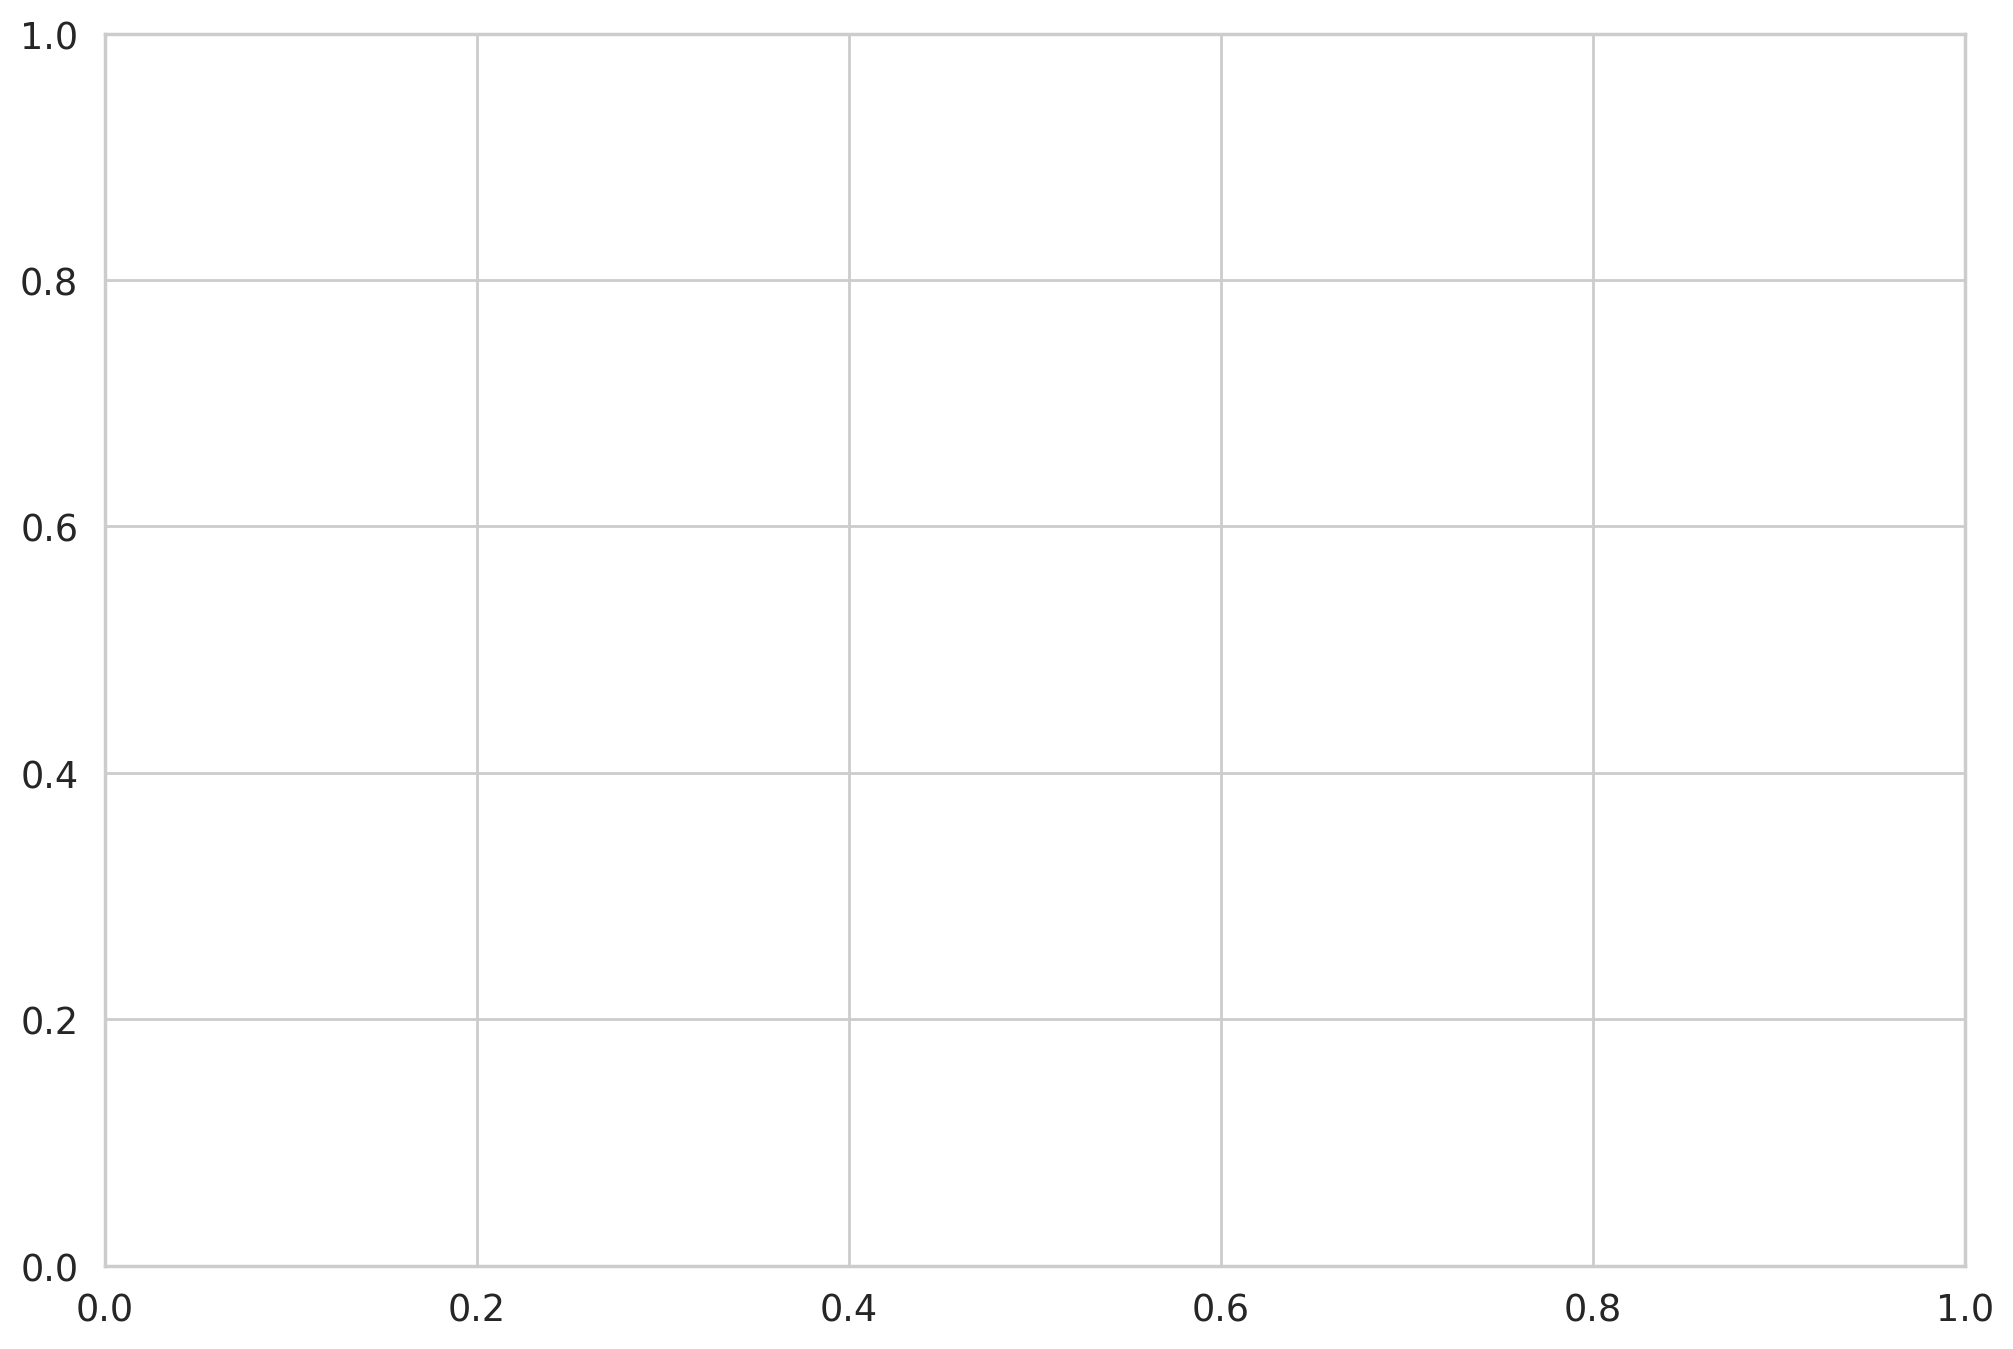

In [ ]:
# Initializing accuracy plot name
acc_plot_name = "imagedetector_accuracy_training_results_10epochs"

# Plotting Training History per epoch (Accuracy) for Image DistilFND
CLASSIFIER_STYLE = "Image Only"

# Plotting training and validation accuracy curves across 20 epochs
plt.plot(history["train_acc"], color="green", label="Training Accuracy")
plt.plot(history["val_acc"], color="red", label="Validation Accuracy")

plt.title("Training History - {classifier}".format(classifier=CLASSIFIER_STYLE))
# Defining x- and y-axis labels
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
# Setting x- and y-axis scale
plt.ylim([0.5, 1])
plt.xlim([0, 10])
plt.legend()
# Saving plotted graph as jpg file
#plt.savefig(f"/content/drive/My Drive/Colab Notebooks/{acc_plot_name}.jpg")
plt.show()

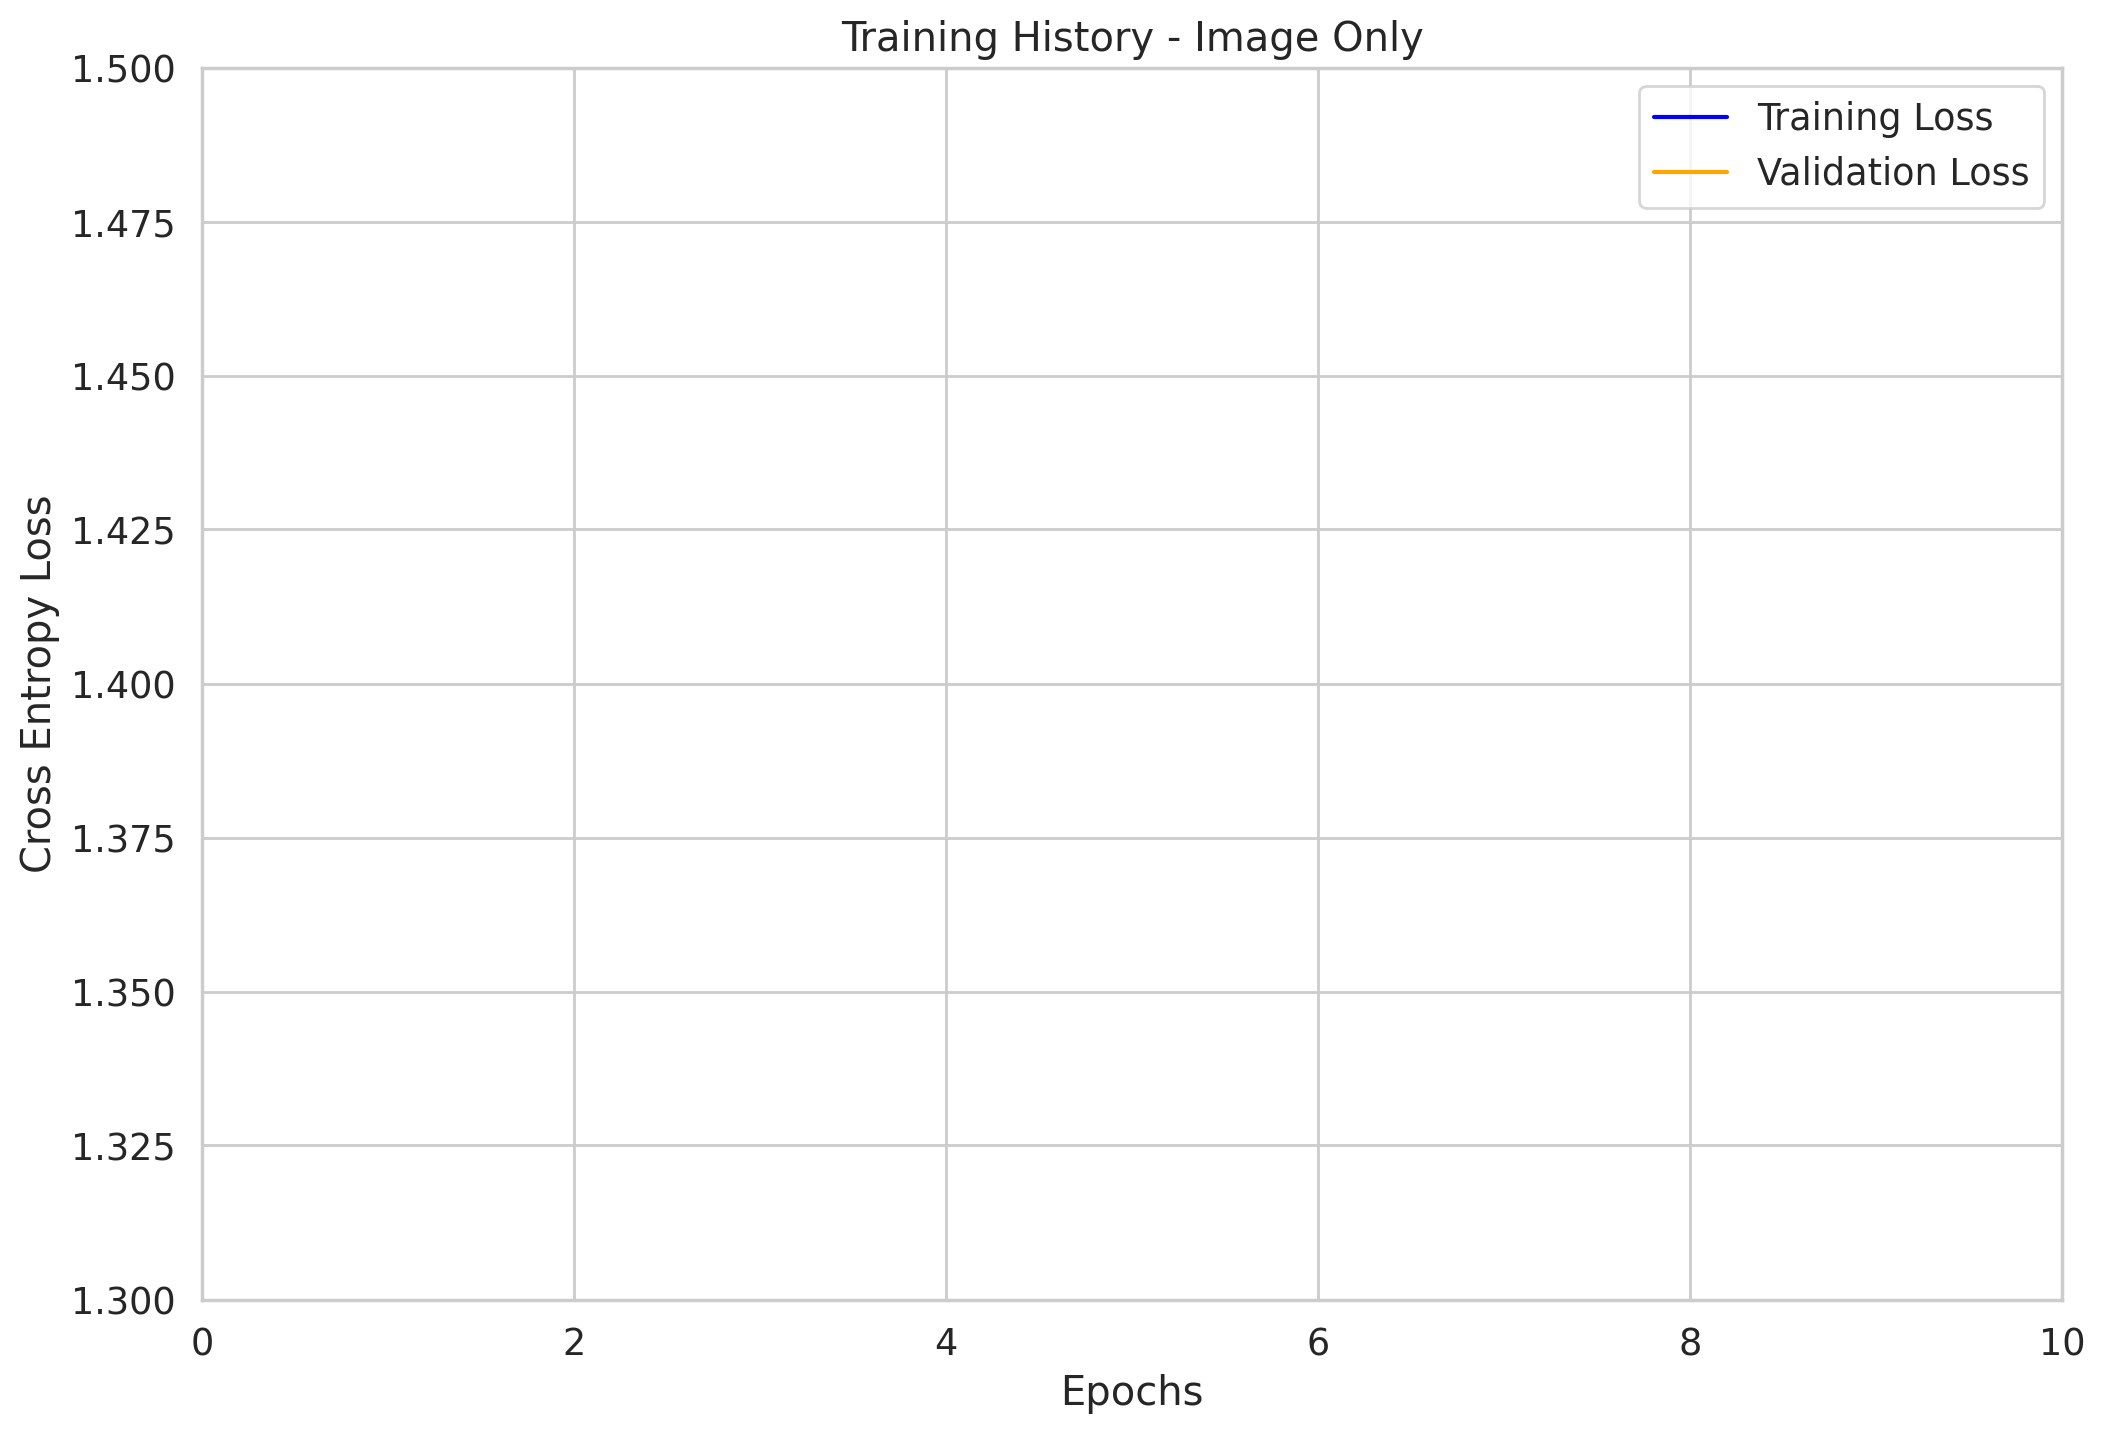

In [ ]:
# Initializing loss plot name
loss_plot_name = "imagedetector_loss_training_results_10epochs"

# Plotting Training History per epoch (Loss) for Image DistilFND
CLASSIFIER_STYLE = "Image Only"

plt.plot(history["train_loss"], color="blue", label="Training Loss")
plt.plot(history["val_loss"], color="orange", label="Validation Loss")

plt.title("Training History - {classifier}".format(classifier=CLASSIFIER_STYLE))
# Defining x- and y-axis labels
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epochs")
# Setting x- and y-axis scale
plt.ylim([1.3, 1.5])
plt.xlim([0, 10])
plt.legend()
# Saving plotted graph as jpg file
#plt.savefig(f"/content/drive/My Drive/Colab Notebooks/{loss_plot_name}.jpg")
plt.show()

In [ ]:
def test_model(model, data_loader, loss_function, device, num_examples):
    print("Testing model in progress...")
    print("-" * 10)

    # Switching off regularization and normalization layers for evaluation mode
    # Hence, no model parameters are adjusted. Model is evaluated in current state
    model.eval()

    # Initializing list of test_losses and correct_preds
    test_losses = []
    correct_preds = 0

    # Initializing lists for predictions,
    # prediction_probs and real_labels
    predictions = []
    prediction_probs = []
    real_labels = []

    # Skipping gradient calulation over weights --> Not needed, because
    # no parameters are updated and significantly speeds up iteration over samples batches
    with torch.no_grad():
        # Iteration over data (batches) contained in data split set DataLoader
        for data in tqdm(data_loader):

            # Initializing post image and label per Reddit-Post and assigning to device
            image = data["image"].to(device)
            labels = data["label"].to(device)

            # Feeding input data to trained Image DistilFND
            outputs = model(
                image = image
            )

            # Final Softmax layer returns class predictions per sample in batch
            # Highest probability value resembles class prediction and is assigned to preds variable
            _, preds = torch.max(outputs, dim=1)

            # Test loss is calculated by applying weighted Cross Entropy Loss
            # on comparison between predicted label and ground truth label
            test_loss = loss_function(outputs, labels)

            # Counting correct model predictions and incrementing correct prediction count
            correct_preds += torch.sum(preds == labels)

            # Appending current test loss per batch
            # to list of test losses
            test_losses.append(test_loss.item())

            # Append calulated values for sample to list of values per sample
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_labels.extend(labels)

    # Stack and concatenate calulated test values per batch
    test_acc = correct_preds.double() / num_examples
    test_loss = np.mean(test_losses)
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    real_labels = torch.stack(real_labels)

    # Return test_acc, test_loss, predictions, prediction_probs, real_labels
    return test_acc, test_loss, predictions, prediction_probs, real_labels

In [ ]:
# Testing model on test data split and initilaizing test values
test_acc, _, y_preds, y_prediction_probs, y_test = test_model(
    fn_detector,
    test_data_loader,
    loss_function,
    device,
    len(df_test)
)

# Printing model test accuracy
print(f"Model testing accuracy for classifier: {CLASSIFIER_STYLE} = {test_acc}%")

Testing model in progress...
----------


  0%|          | 0/221 [00:00<?, ?it/s]

Model testing accuracy for classifier: Image Only = 0.524822695035461%


In [ ]:
# Plotting classification report for test run
print(classification_report(y_test.cpu(), y_preds.cpu(), target_names=CLASS_NAMES))

              precision    recall  f1-score   support

        True       0.50      0.13      0.21      1679
        Fake       0.53      0.88      0.66      1846

    accuracy                           0.52      3525
   macro avg       0.52      0.51      0.43      3525
weighted avg       0.52      0.52      0.44      3525



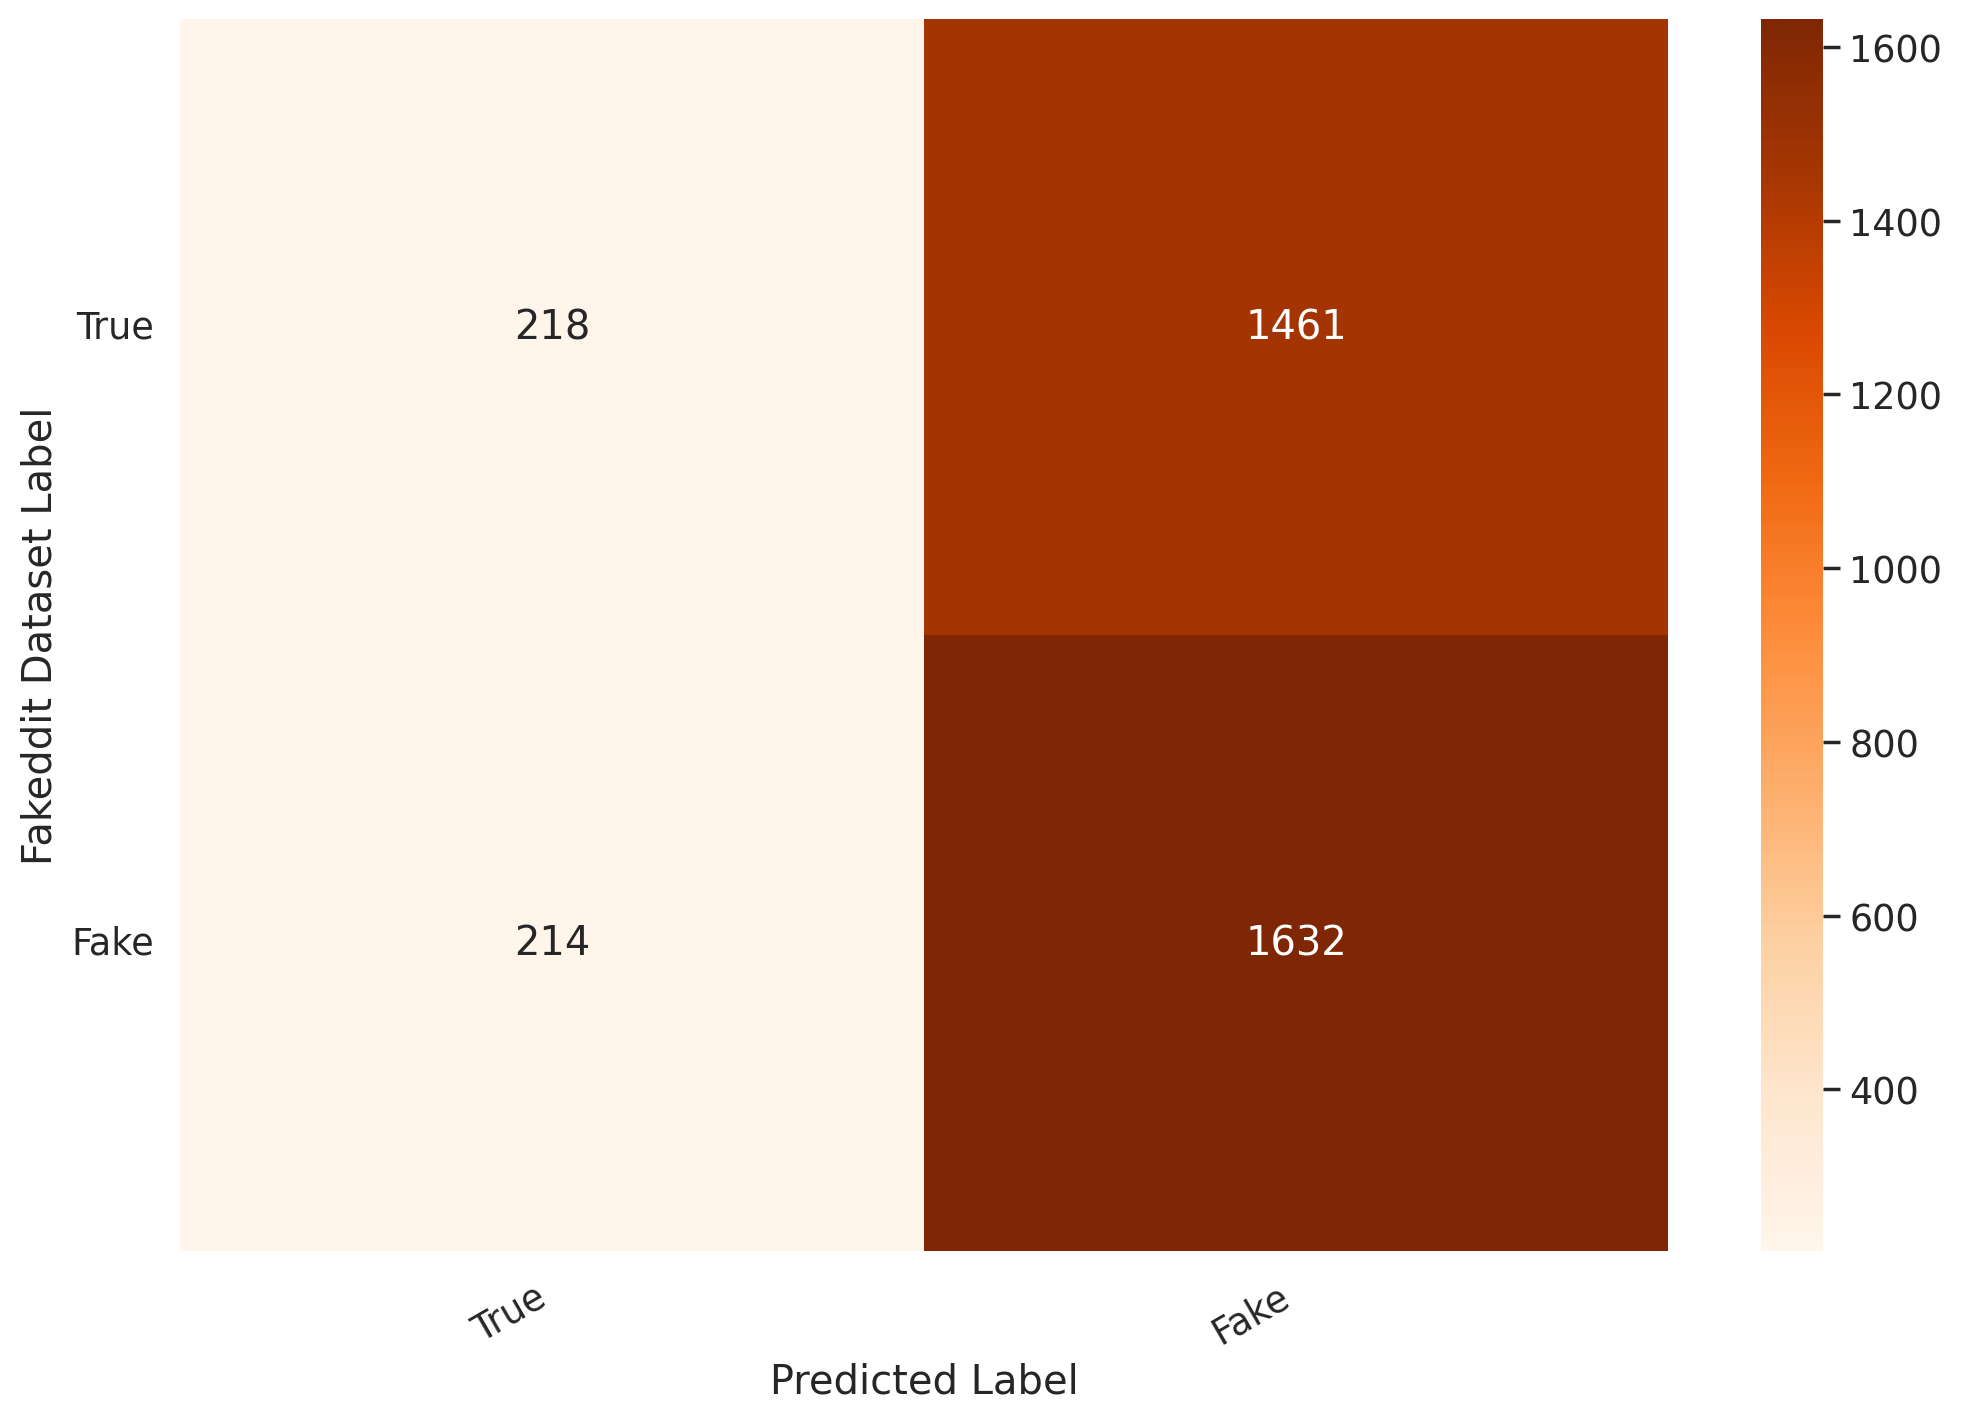

In [ ]:
# Initialize confusion matrix plot name
cm_plot_name = "imagedetector_testing_confusion_matrix_20epochs"

# Function to generate and plot confusion matrix for Image DistilFND
def plot_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Oranges")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha="right")
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha="right")
    # Set x- and y-axis labels
    plt.ylabel("Fakeddit Dataset Label")
    plt.xlabel("Predicted Label")
    # Tighten layout of confusion matrix
    plt.tight_layout

# Initialize confusion_matrix with y_test (ground truth labels) and predicted labels
cm = confusion_matrix(y_test.cpu(), y_preds.cpu())
# Plot and show resulting confusion matrix for Image DistilFND
df_cm = pd.DataFrame(cm, index=CLASS_NAMES, columns=CLASS_NAMES)
plot_confusion_matrix(df_cm)

In [ ]:
# Importing needed modules to calculate ROC-AUC scores
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [ ]:
# Calculating ROC-AUC-Score with One-vs-One and One-vsRest algorithms, regular and weighted by prevalence
macro_roc_auc_ovo = roc_auc_score(y_test.cpu(), y_prediction_probs.cpu(), multi_class="ovo", average="macro")
# weighted_roc_auc_ovo is used for comparison of model variants of DistilFND
weighted_roc_auc_ovo = roc_auc_score(y_test.cpu(), y_prediction_probs.cpu(), multi_class="ovo", average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test.cpu(), y_prediction_probs.cpu(), multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test.cpu(), y_prediction_probs.cpu(), multi_class="ovr", average="weighted")

print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

ValueError: y should be a 1d array, got an array of shape (3525, 2) instead.